In [1]:
from dependencies import *
import torch
import sys
sys.path.append("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/Scripts/Functions")

Loading the saved quick check trained model : train with only 100 samples and validated on only 30 samples, 20 epochs training only from the 32 batch size from these 100 samples

In [2]:
checkpoint_quick_test= torch.load("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/checkpoints/best_model_checkpoint.pth")

In [3]:
#Checking the parameters and keys
print(type(checkpoint_quick_test))

<class 'dict'>


In [4]:
#Checking all model parameters 
for key in checkpoint_quick_test.keys():
    print(key)

epoch
model_state_dict
optimizer_state_dict
loss


In [5]:
#Importing UNet class from Unet.py

In [6]:
import sys
import os
sys.path.append("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/ML_models")

In [7]:
from UNet import UNet
from Downscaling_Dataset_Prep import DownscalingDataset
from Downscaling_Dataset_Prep import PairedDataset

In [8]:
model_instance= UNet(in_channels=2, out_channels=2)
model_instance.load_state_dict(checkpoint_quick_test["model_state_dict"])
model_instance.eval()

UNet(
  (Encoder1): Encoder_Block(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Encoder2): Encoder_Block(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [9]:
#Scaled datasets for testing :loading


In [10]:
precip_input = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Test/SCALED_features_precip_masked_bicubic_test.nc")
temp_input = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Test/SCALED_features_tas_masked_bicubic_test.nc")
precip_target = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Test/SCALED_targets_precip_masked_test.nc")
temp_target= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Test/SCALED_targets_tas_masked_test.nc")

In [11]:
#Building the paired feature-target dataset; first loading individual and coverting them into images

In [12]:
precip_ds= DownscalingDataset(precip_input, precip_target, var_name_inputs="pr", var_name_targets="RhiresD")
temp_ds = DownscalingDataset(temp_input, temp_target, var_name_inputs='tas', var_name_targets='TabsD')


In [13]:
from torch.utils.data import DataLoader

In [14]:
#Now building paired dataset
paired_ds= PairedDataset(precip_ds,temp_ds)


A single prediction : not batch wise

In [15]:
#Predicting one single image pair
index=5
input_img, target_img=paired_ds[index]
input_img= input_img.unsqueeze(0)
model_instance.eval()
with torch.no_grad():
    output_img=model_instance(input_img)

output_img=output_img.squeeze(0)

Whats the time coordinate of this index?

In [16]:
corresponding_time_pr = precip_input['time'].isel(time=index).values
corresponding_time_tas = temp_input['time'].isel(time=index).values

In [17]:
print(corresponding_time_tas)
print(corresponding_time_pr)

1975-06-26T00:00:00.000000000
1975-06-26T00:00:00.000000000


In [18]:
input_img=input_img.squeeze(0)
target_img=target_img.squeeze(0)

In [19]:
target_img.shape

torch.Size([2, 265, 370])

In [20]:
output_img=output_img.squeeze(0)

In [21]:
output_img.shape

torch.Size([2, 265, 370])

The channels were given in unison to the model. For visualisation , it has to be separated. I separate it here for both inpouts and outputs because they have to be plotted side by side for comparison


In [22]:
input_rhiresd= input_img[0,:,:]
input_tabsd= input_img[1,:,:]

In [23]:
target_rhiresd=target_img[0,:,:]
target_tabsd=target_img[1,:,:]

In [24]:
predicted_rhiresd= output_img[0,:,:]
predicted_tabsd= output_img[1,:,:]

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Plotting a single image : input and output image for rhiresd and tabsd side by side

26 June,1975 (TEST SET)

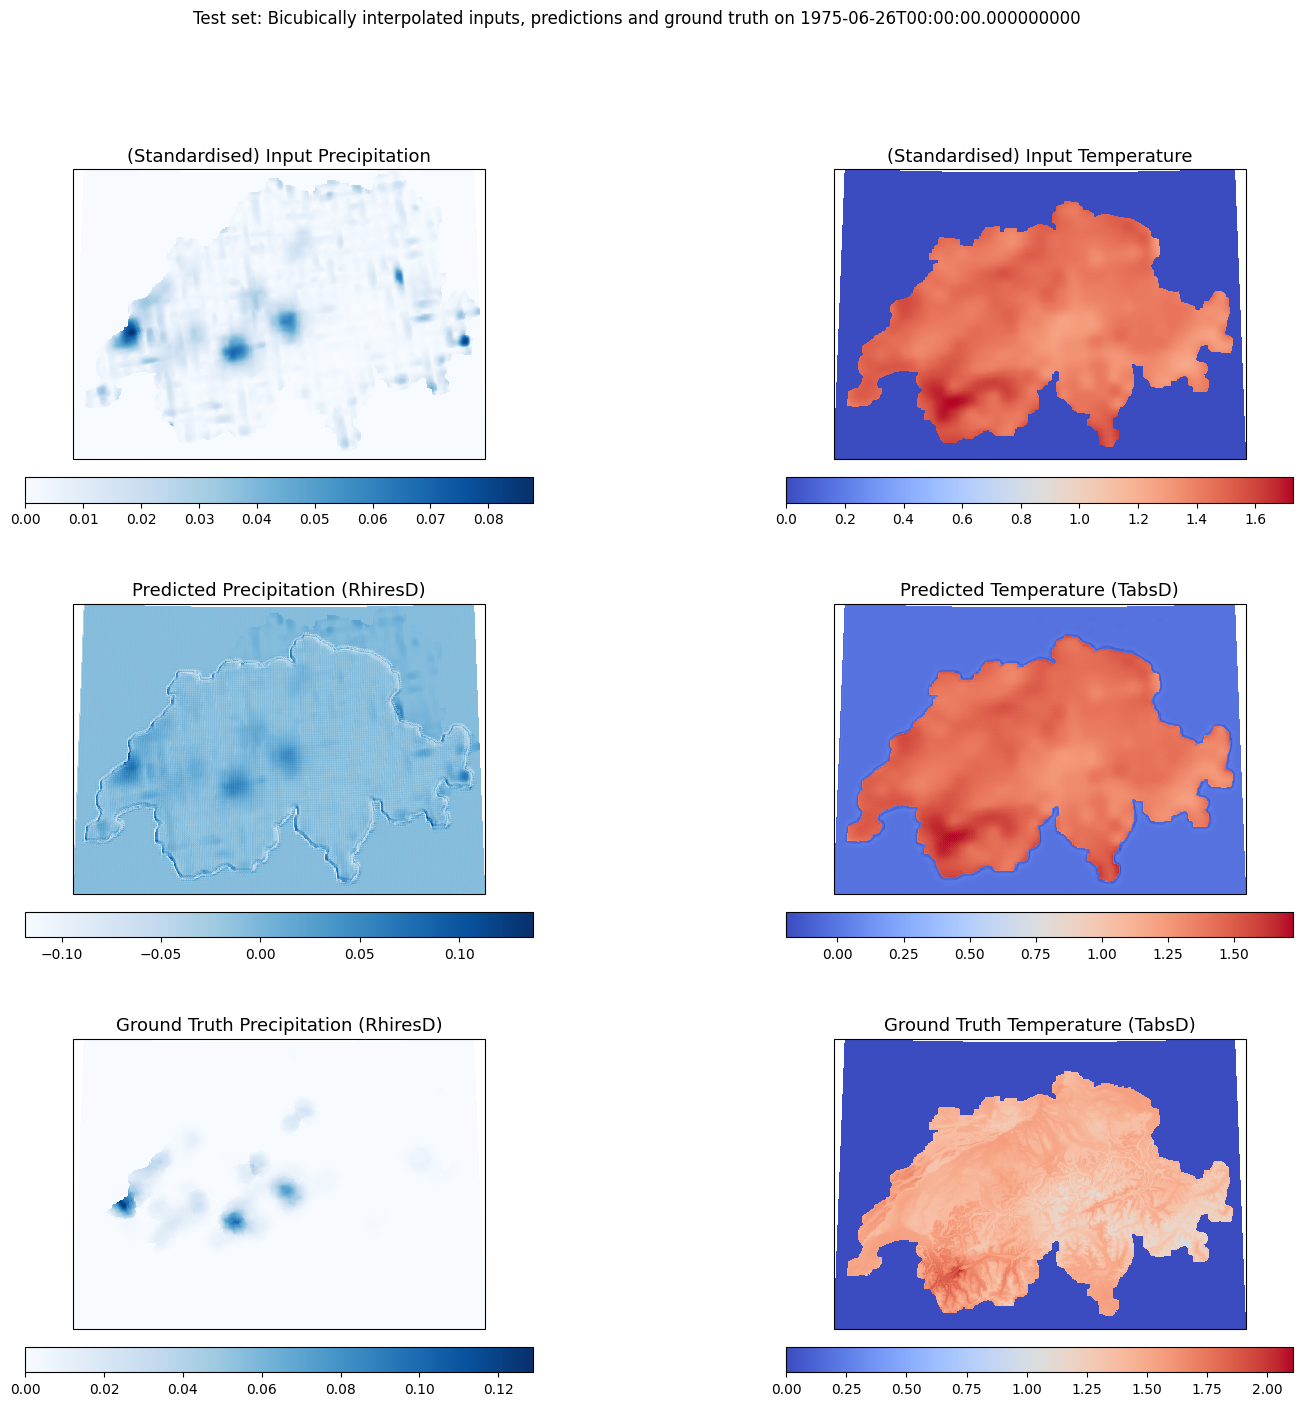

In [26]:
lon_min, lon_max = 5, 11
lat_min, lat_max = 45, 48

lons = np.linspace(lon_min, lon_max, input_rhiresd.shape[1])
lats = np.linspace(lat_min, lat_max, input_rhiresd.shape[0])
lon2d, lat2d = np.meshgrid(lons, lats)


lambert_proj = ccrs.LambertAzimuthalEqualArea(central_longitude=8, central_latitude=47)

fig, axes = plt.subplots(3, 2, figsize=(18, 16), subplot_kw={'projection': lambert_proj})
axes = axes.flatten()

datasets = [
    (input_rhiresd, '(Standardised) Input Precipitation', 'Blues'),
    (input_tabsd, '(Standardised) Input Temperature', 'coolwarm'),
    (predicted_rhiresd, 'Predicted Precipitation (RhiresD)', 'Blues'),
    (predicted_tabsd, 'Predicted Temperature (TabsD)', 'coolwarm'),
    (target_rhiresd, 'Ground Truth Precipitation (RhiresD)', 'Blues'),
    (target_tabsd, 'Ground Truth Temperature (TabsD)', 'coolwarm')
]

for ax, (data, title, cmap) in zip(axes, datasets):
    im = ax.pcolormesh(lon2d, lat2d, data, cmap=cmap, shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(title, fontsize=13)
    ax.coastlines(resolution='10m')
    ax.set_extent([lon2d.min(), lon2d.max(), lat2d.min(), lat2d.max()], crs=ccrs.PlateCarree())
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.ax.tick_params(labelsize=10)

plt.suptitle(f"Test set: Bicubically interpolated inputs, predictions and ground truth on {corresponding_time_pr}",)
plt.show()


Destandardisation of the above uzsing trainign set mean, std, min and max

Inputs reversed with input normalization values (precip_min, precip_max, tas_mean, tas_std).

Targets and Predictions are reversed with target normalization values (target_min, target_max, tabsd_mean, tabsd_std).

In [27]:
from Standardise import standardise
from Standardise import min_max_calculator
from Standardise import norm_params

In [28]:
input_precip_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Train/features_precip_masked_bicubic_train.nc"
input_temp_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Train/features_tas_masked_bicubic_train.nc"

target_precip_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Train/targets_precip_masked_train.nc"
target_temp_path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling/data/processed/Bicubic/Train/targets_tas_masked_train.nc"


In [29]:
input_precip_ds = xr.open_dataset(input_precip_path, chunks={"time": 100})
input_temp_ds = xr.open_dataset(input_temp_path, chunks={"time": 100})
target_precip_ds = xr.open_dataset(target_precip_path, chunks={"time": 100})
target_temp_ds = xr.open_dataset(target_temp_path, chunks={"time": 100})

In [33]:
# NORMALIZATION PARAMETERS using your Standardise.py functions ---
precip_min, precip_max = min_max_calculator(input_precip_ds, var_name="pr")
tas_mean, tas_std = norm_params(input_temp_ds, var_name="tas")

target_min, target_max = min_max_calculator(target_precip_ds, var_name="RhiresD")
tabsd_mean, tabsd_std = norm_params(target_temp_ds, var_name="TabsD")


In [34]:
# --- 3. DESTANDARDIZE SINGLE IMAGES ---

input_img = input_img.squeeze(0)   
target_img = target_img.squeeze(0)
output_img = output_img.squeeze(0)

# Split channels
input_rhiresd = input_img[0, :, :]
input_tabsd = input_img[1, :, :]

target_rhiresd = target_img[0, :, :]
target_tabsd = target_img[1, :, :]

predicted_rhiresd = output_img[0, :, :]
predicted_tabsd = output_img[1, :, :]

# --- Now destandardize each one ---

# INPUTS (input normalization)
input_rhiresd_orig = input_rhiresd * (precip_max - precip_min) + precip_min
input_tabsd_orig = input_tabsd * tas_std + tas_mean

target_rhiresd_orig = target_rhiresd * (target_max - target_min) + target_min
target_tabsd_orig = target_tabsd * tabsd_std + tabsd_mean

predicted_rhiresd_orig = predicted_rhiresd * (target_max - target_min) + target_min
predicted_tabsd_orig = predicted_tabsd * tabsd_std + tabsd_mean


print("Single input, output, and ground truth images destandardized ✅")


Single input, output, and ground truth images destandardized ✅


In [35]:
#Plotting destandardised images

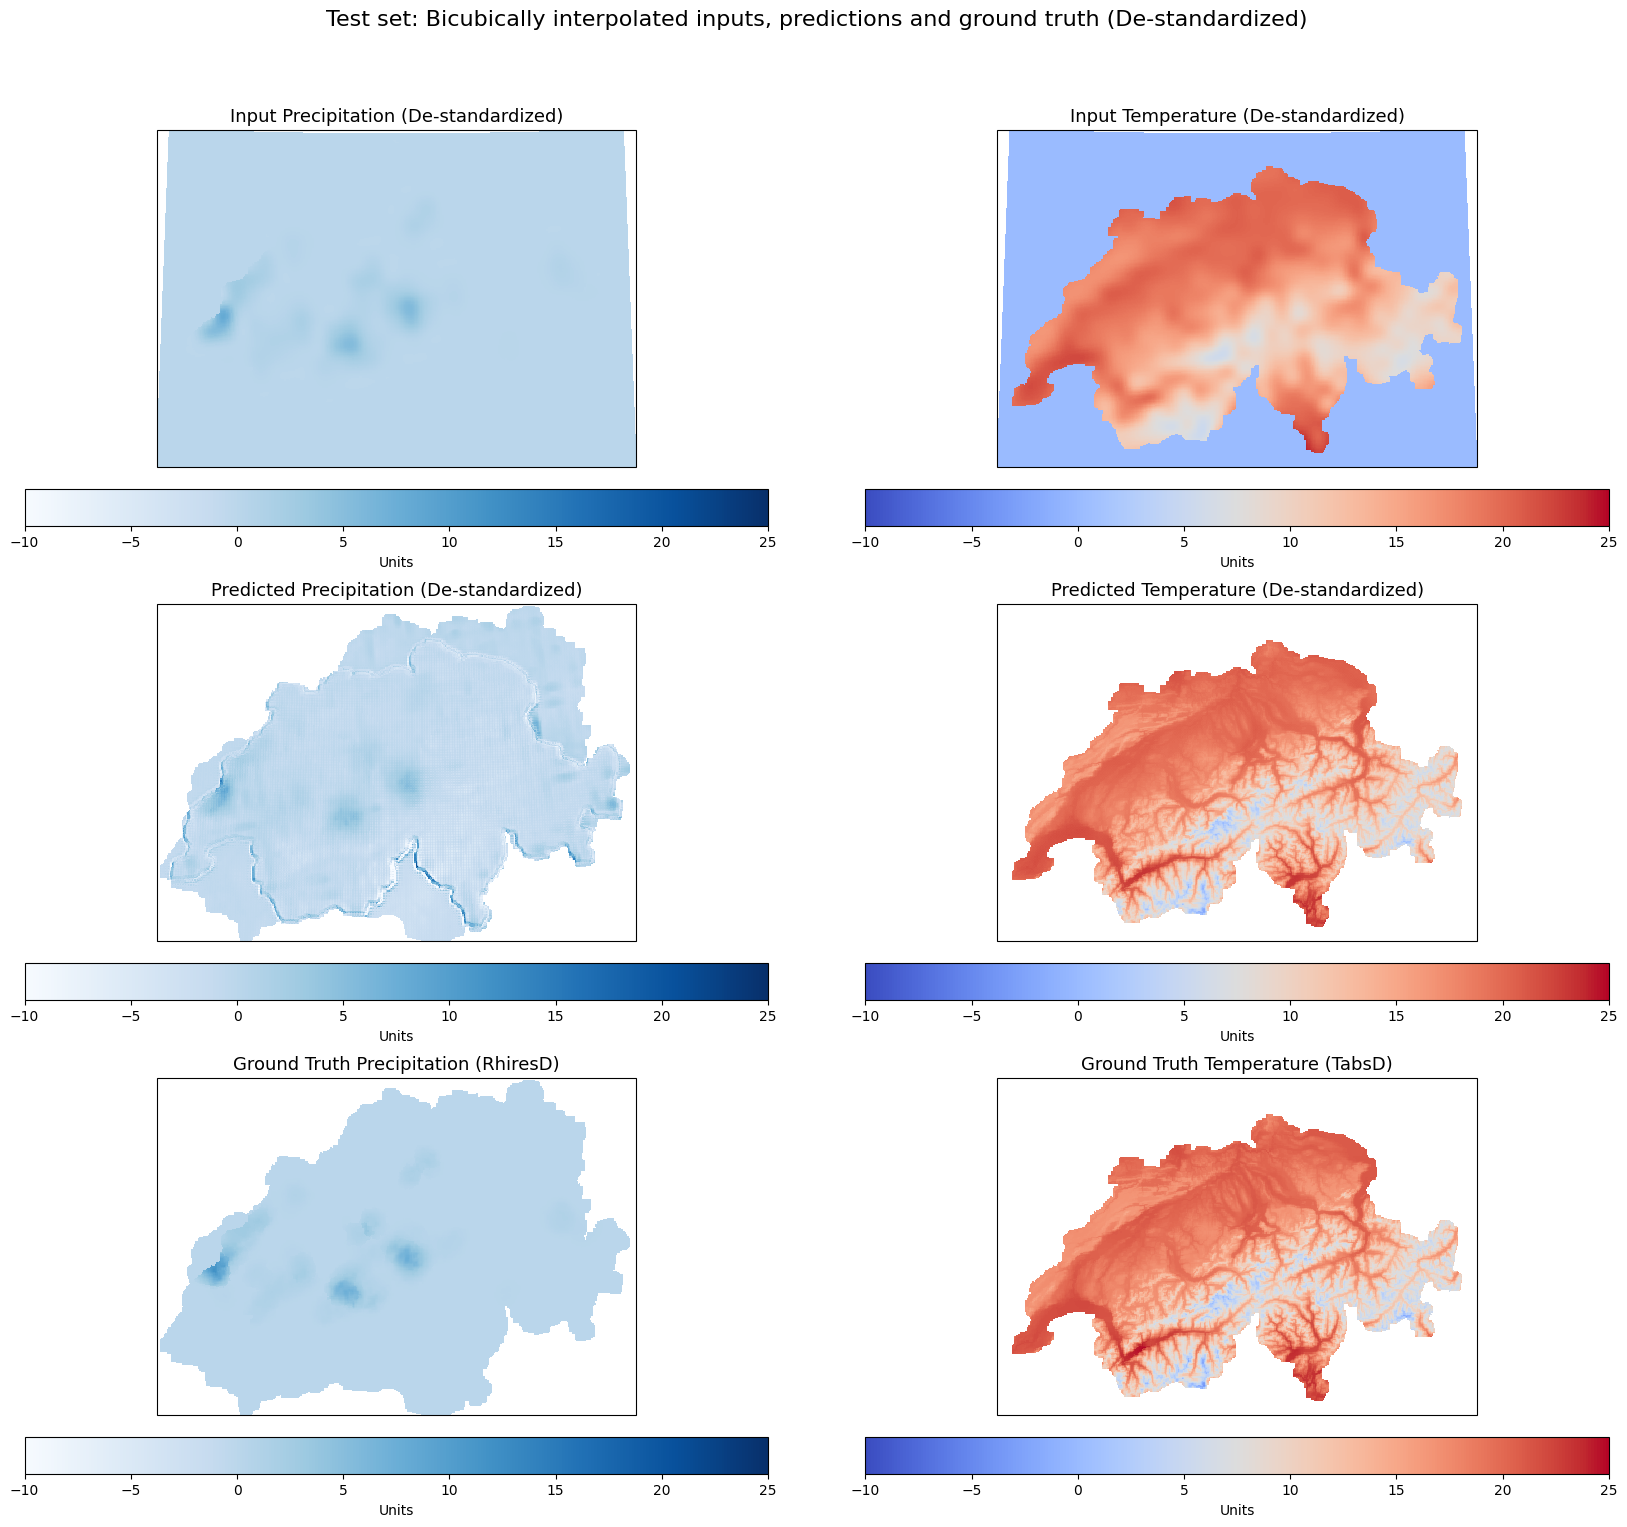

In [ ]:
lon_min, lon_max = 5, 11
lat_min, lat_max = 45, 48

lons = np.linspace(lon_min, lon_max, input_rhiresd_orig.shape[1])
lats = np.linspace(lat_min, lat_max, input_rhiresd_orig.shape[0])
lon2d, lat2d = np.meshgrid(lons, lats)

# Set Lambert projection
lambert_proj = ccrs.LambertAzimuthalEqualArea(central_longitude=8, central_latitude=47)

# Create figure
fig, axes = plt.subplots(3, 2, figsize=(18, 16), subplot_kw={'projection': lambert_proj})
axes = axes.flatten()

# Create datasets: Now using DE-STANDARDIZED data
datasets = [
    (input_rhiresd_orig, 'Input Precipitation (De-standardized)', 'Blues'),
    (input_tabsd_orig, 'Input Temperature (De-standardized)', 'coolwarm'),
    (predicted_rhiresd_orig, 'Predicted Precipitation (De-standardized)', 'Blues'),
    (predicted_tabsd_orig, 'Predicted Temperature (De-standardized)', 'coolwarm'),
    (target_rhiresd_orig, 'Ground Truth Precipitation (RhiresD)', 'Blues'),
    (target_tabsd_orig, 'Ground Truth Temperature (TabsD)', 'coolwarm')
]

# Plot
for ax, (data, title, cmap) in zip(axes, datasets):
    im = ax.pcolormesh(
        lon2d, lat2d, data, cmap=cmap, shading='auto', transform=ccrs.PlateCarree(),
        vmin=-10, vmax=25  
    )
    ax.set_title(title, fontsize=13)
    ax.coastlines(resolution='10m')
    ax.set_extent([lon2d.min(), lon2d.max(), lat2d.min(), lat2d.max()], crs=ccrs.PlateCarree())
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label('Units', fontsize=10) 

# Global title
plt.suptitle(f"Test set: Bicubically interpolated inputs, predictions and ground truth (De-standardized)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
